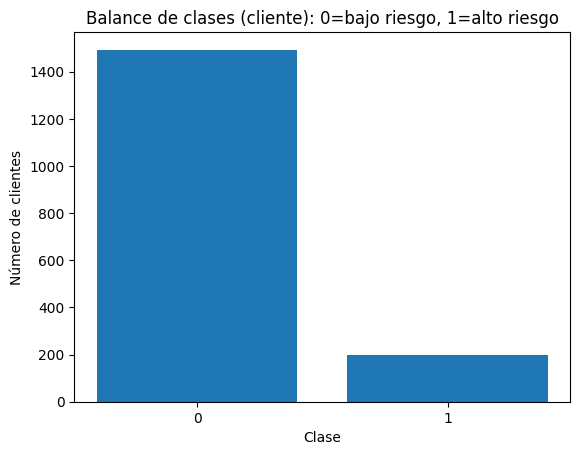

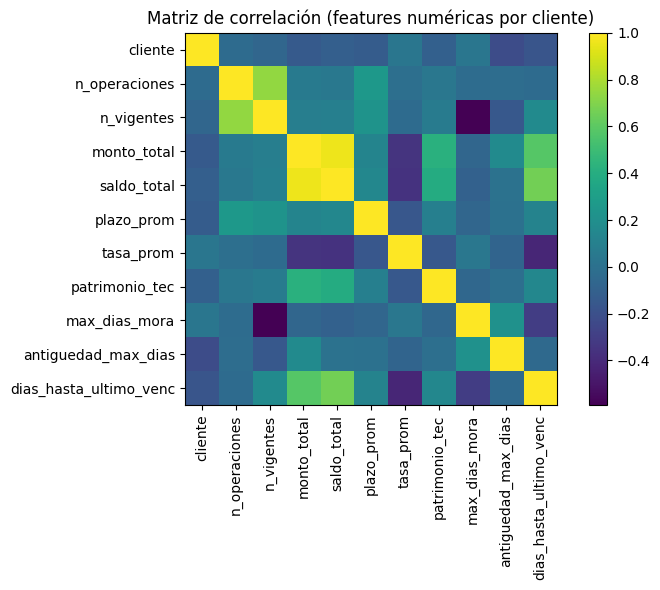

Confusion matrix:
 [[373   0]
 [ 37  13]]

Classification report:
               precision    recall  f1-score   support

           0     0.9098    1.0000    0.9527       373
           1     1.0000    0.2600    0.4127        50

    accuracy                         0.9125       423
   macro avg     0.9549    0.6300    0.6827       423
weighted avg     0.9204    0.9125    0.8889       423

ROC AUC: 0.7438


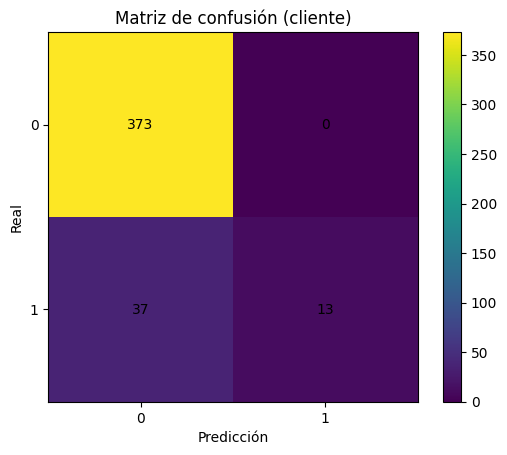

<Figure size 640x480 with 0 Axes>

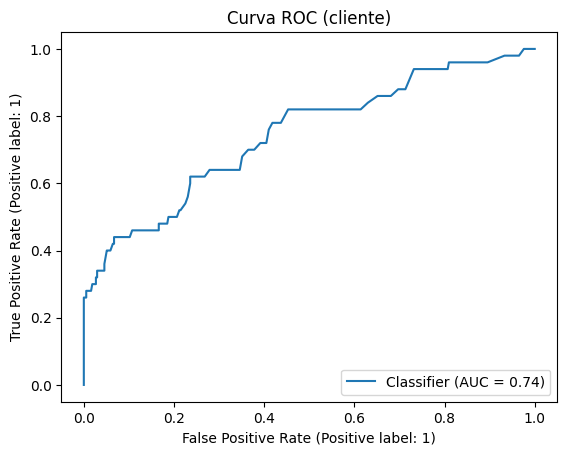


✅ Modelo guardado en: C:\ML_cooperativa\data\credit_risk_customer_model.joblib


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

# =====================
# CONFIG
# =====================
BASE_DIR = Path(__file__).resolve().parent  # .../ML_cooperativa/data
EXCEL_PATH = BASE_DIR / "BDD_COACTULCAN.xlsx"
MODEL_OUT = BASE_DIR.parent / "data" / "models" / "credit_risk_customer_model.joblib"
MODEL_OUT.parent.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.25
PROBA_THRESHOLD = 0.5

# Target definido por tu regla:
# riesgo alto si existe al menos una operación con dias_mora > 0
MORA_UMBRAL = 0


# =====================
# UTILIDADES
# =====================
def pick_col(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

def mode_or_nan(s):
    s = s.dropna()
    if len(s) == 0:
        return np.nan
    return s.astype(str).mode().iloc[0]

def count_vigentes(s):
    s = s.dropna().astype(str).str.upper()
    return (s == "VIGENTE").sum()


# =====================
# 1) CARGA + LIMPIEZA BASE
# =====================
def load_and_clean(excel_path: Path) -> pd.DataFrame:
    df = pd.read_excel(excel_path)
    df.columns = df.columns.astype(str).str.strip().str.replace("\n", " ", regex=False)
    return df


# =====================
# 2) AGREGACIÓN POR CLIENTE
# =====================
def build_customer_table(df: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    cols = df.columns.tolist()

    col_cliente = pick_col(cols, ["cliente", "Cliente", "CLIENTE"])
    col_oficina = pick_col(cols, ["oficina", "Oficina", "OFICINA"])
    col_estado = pick_col(cols, ["estado", "Estado", "ESTADO"])
    col_fecha_conc = pick_col(cols, ["fecha_concesión", "fecha_concesion"])
    col_fecha_venc = pick_col(cols, ["fechavencimiento", "fecha_vencimiento", "fecha vencimiento"])
    col_fecha_corte = pick_col(cols, ["fecha_corte_base", "fecha corte base", "Fecha corte base"])
    col_monto = pick_col(cols, ["monto_otorgado", "monto otorgado", "Monto otorgado"])
    col_saldo = pick_col(cols, ["Saldo total", "saldo total", "SALDO TOTAL", "saldo"])
    col_tipo = pick_col(cols, ["Tipo de Crédito", "tipo de crédito", "Tipo de credito", "tipo"])
    col_plazo = pick_col(cols, ["Plazo del Crédito", "plazo del crédito", "plazo"])
    col_tasa = pick_col(cols, ["tasa_de_interes", "tasa de interes", "tasa", "tasa_de_interés"])
    col_garantia = pick_col(cols, ["GARANTIA", "garantia", "Garantia"])
    col_calif = pick_col(cols, ["calificacion_riesgo", "calificación_riesgo", "calificacion riesgo"])  # SOLO contraste
    col_dias_mora = pick_col(cols, ["dias mora", "días mora", "dias_mora", "dias de mora"])
    col_patrimonio = pick_col(cols, ["patrimonio_tec", "patrimonio tec", "patrimonio"])
    col_sexo = pick_col(cols, ["qy_sexo", "sexo", "Sexo"])

    if col_cliente is None or col_dias_mora is None:
        raise ValueError(f"Columnas obligatorias no encontradas: cliente={col_cliente}, dias_mora={col_dias_mora}")

    # Tipado
    for c in [col_fecha_conc, col_fecha_venc, col_fecha_corte]:
        if c is not None:
            df[c] = pd.to_datetime(df[c], errors="coerce")

    for c in [col_monto, col_saldo, col_plazo, col_tasa, col_dias_mora, col_patrimonio]:
        if c is not None:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    grp = df.groupby(col_cliente, dropna=False)

    cust = pd.DataFrame({
        "cliente": grp.size().index,
        "n_operaciones": grp.size().values,
        "n_vigentes": grp[col_estado].apply(count_vigentes).values if col_estado else np.nan,
        "monto_total": grp[col_monto].sum(min_count=1).values if col_monto else np.nan,
        "saldo_total": grp[col_saldo].sum(min_count=1).values if col_saldo else np.nan,
        "plazo_prom": grp[col_plazo].mean().values if col_plazo else np.nan,
        "tasa_prom": grp[col_tasa].mean().values if col_tasa else np.nan,
        "patrimonio_tec": grp[col_patrimonio].max().values if col_patrimonio else np.nan,
        # Para target:
        "max_dias_mora": grp[col_dias_mora].max().values,
    })

    # Categorías útiles como contexto “operativo”
    if col_oficina:
        cust["oficina_mode"] = grp[col_oficina].apply(mode_or_nan).values
    if col_tipo:
        cust["tipo_credito_mode"] = grp[col_tipo].apply(mode_or_nan).values
    if col_garantia:
        cust["garantia_mode"] = grp[col_garantia].apply(mode_or_nan).values
    if col_sexo:
        cust["sexo_mode"] = grp[col_sexo].apply(mode_or_nan).values

    # Features temporales agregadas (si existen)
    if col_fecha_corte and col_fecha_conc:
        cust["antiguedad_max_dias"] = (grp[col_fecha_corte].max() - grp[col_fecha_conc].min()).dt.days.values
    else:
        cust["antiguedad_max_dias"] = np.nan

    if col_fecha_corte and col_fecha_venc:
        cust["dias_hasta_ultimo_venc"] = (grp[col_fecha_venc].max() - grp[col_fecha_corte].max()).dt.days.values
    else:
        cust["dias_hasta_ultimo_venc"] = np.nan

    # Target según tu regla
    cust["target_riesgo_alto"] = (cust["max_dias_mora"].fillna(0) > MORA_UMBRAL).astype(int)

    # Campo de contraste (NO entrenamiento)
    if col_calif:
        cust["calificacion_riesgo_mode"] = grp[col_calif].apply(mode_or_nan).values

    meta = {
        "col_cliente": col_cliente,
        "col_dias_mora": col_dias_mora,
        "col_calif": col_calif
    }
    return cust, meta


# =====================
# 3) ENTRENAMIENTO (SIN USAR 'mora' COMO FEATURE)
# =====================
def train_customer_model(cust: pd.DataFrame) -> tuple[Pipeline, dict, np.ndarray, np.ndarray, np.ndarray]:
    y = cust["target_riesgo_alto"].copy()

    # ❗️Excluimos cualquier variable de mora y derivados directos del target
    drop_cols = ["cliente", "target_riesgo_alto", "max_dias_mora", "calificacion_riesgo_mode"]
    X = cust.drop(columns=[c for c in drop_cols if c in cust.columns], errors="ignore")

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols),
        ],
        remainder="drop"
    )

    model = RandomForestClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1,
    )

    clf = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    clf.fit(X_train, y_train)

    proba = clf.predict_proba(X_test)[:, 1]
    pred = (proba >= PROBA_THRESHOLD).astype(int)

    report = {
        "confusion_matrix": confusion_matrix(y_test, pred),
        "classification_report": classification_report(y_test, pred, digits=4),
        "roc_auc": roc_auc_score(y_test, proba)
    }

    return clf, report, y_test.to_numpy(), pred, proba


# =====================
# 4) VISUALIZACIONES (4 GRÁFICAS)
# =====================
def plot_class_balance(cust: pd.DataFrame):
    counts = cust["target_riesgo_alto"].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Balance de clases (cliente): 0=bajo riesgo, 1=alto riesgo")
    plt.xlabel("Clase")
    plt.ylabel("Número de clientes")
    plt.show()

def plot_confusion_matrix(cm: np.ndarray):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Matriz de confusión (cliente)")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar()
    plt.show()

def plot_roc(y_true: np.ndarray, proba: np.ndarray):
    plt.figure()
    RocCurveDisplay.from_predictions(y_true, proba)
    plt.title("Curva ROC (cliente)")
    plt.show()

def plot_numeric_correlation(cust: pd.DataFrame):
    num = cust.select_dtypes(include=["number"]).drop(columns=["target_riesgo_alto"], errors="ignore")
    corr = num.corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, interpolation="nearest")
    plt.title("Matriz de correlación (features numéricas por cliente)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


# =====================
# MAIN
# =====================
def main():
    df = load_and_clean(EXCEL_PATH)
    cust, meta = build_customer_table(df)

    # 4 gráficas de sanity/diagnóstico
    plot_class_balance(cust)
    plot_numeric_correlation(cust)

    clf, report, y_true, y_pred, proba = train_customer_model(cust)

    print("Confusion matrix:\n", report["confusion_matrix"])
    print("\nClassification report:\n", report["classification_report"])
    print(f"ROC AUC: {report['roc_auc']:.4f}")

    plot_confusion_matrix(report["confusion_matrix"])
    plot_roc(y_true, proba)

    artifact = {
        "pipeline": clf,
        "target_definition": "Riesgo alto si existe al menos una operación con dias_mora > 0 (por cliente)",
        "threshold_proba": PROBA_THRESHOLD,
        "training_level": "customer_aggregate",
        "excluded_from_training": ["max_dias_mora", "calificacion_riesgo_mode (contraste)"],
        "meta": meta
    }

    joblib.dump(artifact, MODEL_OUT)
    print(f"\n✅ Modelo guardado en: {MODEL_OUT.resolve()}")

if __name__ == "__main__":
    main()


In [1]:
pip list

Package                                  Version
---------------------------------------- ---------------
absl-py                                  1.4.0
aio-pika                                 8.2.3
aiofiles                                 24.1.0
aiogram                                  2.15
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.0
aiohttp-retry                            2.9.1
aiormq                                   6.4.2
aiosignal                                1.4.0
annotated-doc                            0.0.3
annotated-types                          0.7.0
anyio                                    4.11.0
APScheduler                              3.9.1.post1
argon2-cffi                              25.1.0
argon2-cffi-bindings                     25.1.0
arrow                                    1.3.0
asgiref                                  3.11.0
asttokens                                3.0.0
astunparse                           


[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
